In [1]:
# Run in Colab or local env
%pip install -q tensorflow matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# Simple toy corpus (small sentences)
corpus = [
    "i love deep learning",
    "i love artificial intelligence",
    "deep learning is fun",
    "artificial intelligence is cool",
    "i love models",
    "models learn patterns"
]

# Build tokenizer (word-level for simplicity)
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', lower=True, oov_token='<OOV>')
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
index_word = {i:w for w,i in word_index.items()}

vocab_size = len(word_index) + 1  # +1 for padding 0
print("Vocab size:", vocab_size)
print("Word index sample:", list(word_index.items())[:10])

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(corpus)
print("Sequences:", sequences)

# For next-token prediction prepare input->target pairs (shifted sequences)
inputs = []
targets = []
max_len = max(len(s) for s in sequences)

for s in sequences:
    for i in range(1, len(s)):
        inputs.append(s[:i])       # tokens [0..i-1]
        targets.append(s[i])       # next token

# Pad inputs
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=max_len, padding='pre')
targets = np.array(targets)

print("Example input (padded):", inputs[0], "target:", targets[0])


Vocab size: 14
Word index sample: [('<OOV>', 1), ('i', 2), ('love', 3), ('deep', 4), ('learning', 5), ('artificial', 6), ('intelligence', 7), ('is', 8), ('models', 9), ('fun', 10)]
Sequences: [[2, 3, 4, 5], [2, 3, 6, 7], [4, 5, 8, 10], [6, 7, 8, 11], [2, 3, 9], [9, 12, 13]]
Example input (padded): [0 0 0 2] target: 3


In [5]:
embed_dim = 16  # small, for demonstration

embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
# Test embedding
sample_ids = tf.constant(inputs[:2])
emb = embedding_layer(sample_ids)
print("Embedding shape:", emb.shape)  # (batch, seq_len, embed_dim)


Embedding shape: (2, 4, 16)


In [6]:
def positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]  # (seq_len, 1)
    i = np.arange(d_model)[np.newaxis, :]    # (1, d_model)
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates  # (seq_len, d_model)

    # apply sin to even indices and cos to odd indices
    sines = np.sin(angle_rads[:, 0::2])
    coses = np.cos(angle_rads[:, 1::2])
    pos_encoding = np.zeros(angle_rads.shape)
    pos_encoding[:, 0::2] = sines
    pos_encoding[:, 1::2] = coses
    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)  # shape (1, seq_len, d_model)

# Example:
pos_enc = positional_encoding(max_len, embed_dim)
print("Pos encoding shape:", pos_enc.shape)


Pos encoding shape: (1, 4, 16)


In [7]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    # Q, K, V shapes: (batch, heads, seq_len, depth)
    matmul_qk = tf.matmul(Q, K, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    dk = tf.cast(tf.shape(K)[-1], tf.float32)
    scaled_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, V)  # (..., seq_len_q, depth_v)
    return output, attention_weights


In [8]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.d_model = d_model

        self.Wq = tf.keras.layers.Dense(d_model)
        self.Wk = tf.keras.layers.Dense(d_model)
        self.Wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x):
        # x shape: (batch, seq_len, d_model) -> (batch, num_heads, seq_len, depth)
        x = tf.reshape(x, (tf.shape(x)[0], tf.shape(x)[1], self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x, mask=None):
        Q = self.Wq(x)  # (batch, seq, d_model)
        K = self.Wk(x)
        V = self.Wv(x)

        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)

        attn_output, attn_weights = scaled_dot_product_attention(Q, K, V, mask)
        # attn_output: (batch, num_heads, seq_len, depth)
        attn_output = tf.transpose(attn_output, perm=[0, 2, 1, 3])  # (batch, seq_len, num_heads, depth)
        concat = tf.reshape(attn_output, (tf.shape(attn_output)[0], tf.shape(attn_output)[1], self.d_model))  # (batch, seq_len, d_model)
        output = self.dense(concat)
        return output, attn_weights  # attn_weights: (batch, num_heads, seq_len, seq_len)


In [9]:
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.mha = MultiHeadSelfAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask=None):
        attn_output, attn_weights = self.mha(x, mask=mask)  # (batch, seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # residual

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # residual

        return out2, attn_weights


In [10]:
class MiniTransformer(tf.keras.Model):
    def __init__(self, vocab_size, max_len, d_model=16, num_heads=2, num_layers=2, dff=64, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_len, d_model)
        self.enc_layers = [TransformerEncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        self.final_dense = tf.keras.layers.Dense(vocab_size)  # predict next token id logits

    def call(self, x, training=False, mask=None):
        # x: (batch, seq_len)
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)  # (batch, seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # scale embeddings
        x += self.pos_encoding[:, -seq_len:, :]  # broadcast, add positional encoding
        x = self.dropout(x, training=training)

        all_attn_weights = []
        for enc_layer in self.enc_layers:
            x, attn_weights = enc_layer(x, training=training, mask=mask)
            all_attn_weights.append(attn_weights)

        logits = self.final_dense(x)  # (batch, seq_len, vocab_size)
        return logits, all_attn_weights  # return attention weights from each layer


In [14]:
# inputs: list of padded sequences; targets: next-token ids
inputs = np.array(inputs)  # (N_examples, seq_len)
targets = targets  # (N_examples,)

# We'll train with batches; our model outputs logits for each position,
# but we will only train on the last (rightmost) non-pad position.
# Find index of first non-zero token in each padded input to locate last real token.
seq_len = inputs.shape[1]

# Build sample weights and labels that only consider last real token (mask)
y = []  # expected labels will be shaped (N, seq_len) but we zero-out except last token
y_masked = np.zeros((inputs.shape[0], seq_len), dtype=np.int32)  # we will encode -1 where unused
y_labels = np.full((inputs.shape[0], seq_len), -1)  # -1 means ignore in loss

for i, inp in enumerate(inputs):
    # find index of last non-zero
    nonzeros = np.where(inp != 0)[0]
    if len(nonzeros) == 0:
        last_idx = seq_len - 1
    else:
        last_idx = nonzeros[-1]  # last real token index
    # We want to predict the token that follows this input. Our 'target' variable already gives next token id.
    # We'll place it at position last_idx (so model predicts target at that position)
    y_labels[i, last_idx] = targets[i]

# ✅ Fix dtype mismatch
y_labels = y_labels.astype('int32')

# We'll use a custom loss that only counts positions where label != -1
print("inputs shape:", inputs.shape, "y_labels shape:", y_labels.shape)


inputs shape: (16, 4) y_labels shape: (16, 4)


In [15]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def masked_loss(y_true, y_pred):
    # y_true: (batch, seq_len) with -1 where ignore; y_pred: (batch, seq_len, vocab)
    mask = tf.not_equal(y_true, -1)
    y_true_filtered = tf.boolean_mask(y_true, mask)
    y_pred_filtered = tf.boolean_mask(y_pred, mask)
    loss = loss_object(y_true_filtered, y_pred_filtered)
    return tf.reduce_mean(loss)

def masked_accuracy(y_true, y_pred):
    mask = tf.not_equal(y_true, -1)
    y_true_filtered = tf.boolean_mask(y_true, mask)
    y_pred_filtered = tf.boolean_mask(y_pred, mask)
    pred_ids = tf.argmax(y_pred_filtered, axis=-1, output_type=tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(pred_ids, y_true_filtered), tf.float32))
    return acc


In [17]:
# Build model
model = MiniTransformer(vocab_size=vocab_size, max_len=inputs.shape[1],
                        d_model=embed_dim, num_heads=2, num_layers=2, dff=64, rate=0.1)

# Dummy call to build weights
_ = model(tf.constant(inputs[:2]), training=False)

# Custom training with Keras fit requires wrapping to produce (y_true, y_pred)
# We can use a tf.data.Dataset
batch_size = 8
dataset = tf.data.Dataset.from_tensor_slices((inputs, y_labels))
dataset = dataset.shuffle(100).batch(batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Training loop
epochs = 1000
for epoch in range(epochs):
    epoch_loss = 0.0
    epoch_acc = 0.0
    steps = 0
    for batch_x, batch_y in dataset:
        with tf.GradientTape() as tape:
            logits, _ = model(batch_x, training=True)  # (batch, seq_len, vocab)
            loss = masked_loss(batch_y, logits)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        acc = masked_accuracy(batch_y, logits)
        epoch_loss += loss.numpy()
        epoch_acc += acc.numpy()
        steps += 1
    print(f"Epoch {epoch+1}/{epochs} — loss: {epoch_loss/steps:.4f} — acc: {epoch_acc/steps:.4f}")


Epoch 1/1000 — loss: 3.0976 — acc: 0.0625
Epoch 2/1000 — loss: 2.8945 — acc: 0.1250
Epoch 3/1000 — loss: 2.7267 — acc: 0.1875
Epoch 4/1000 — loss: 2.7012 — acc: 0.1250
Epoch 5/1000 — loss: 2.8589 — acc: 0.0000
Epoch 6/1000 — loss: 2.5995 — acc: 0.1250
Epoch 7/1000 — loss: 2.5731 — acc: 0.1875
Epoch 8/1000 — loss: 2.7244 — acc: 0.1875
Epoch 9/1000 — loss: 2.3657 — acc: 0.2500
Epoch 10/1000 — loss: 2.5428 — acc: 0.1875
Epoch 11/1000 — loss: 2.3958 — acc: 0.3125
Epoch 12/1000 — loss: 2.2990 — acc: 0.2500
Epoch 13/1000 — loss: 2.3705 — acc: 0.1250
Epoch 14/1000 — loss: 2.4779 — acc: 0.1875
Epoch 15/1000 — loss: 2.6996 — acc: 0.1250
Epoch 16/1000 — loss: 2.5813 — acc: 0.2500
Epoch 17/1000 — loss: 2.3731 — acc: 0.1875
Epoch 18/1000 — loss: 2.3593 — acc: 0.1875
Epoch 19/1000 — loss: 2.1778 — acc: 0.2500
Epoch 20/1000 — loss: 2.4294 — acc: 0.1875
Epoch 21/1000 — loss: 2.1188 — acc: 0.5000
Epoch 22/1000 — loss: 2.1915 — acc: 0.2500
Epoch 23/1000 — loss: 2.2268 — acc: 0.1875
Epoch 24/1000 — loss

Number of layers' attn returned: 2


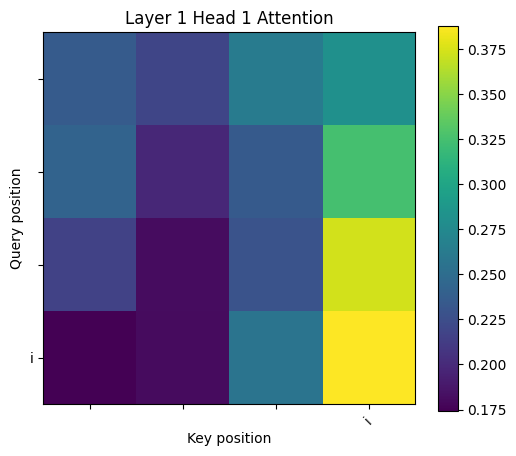

In [18]:
# Choose an example input (index 0)
sample_input = inputs[0:1]  # shape (1, seq_len)
logits, all_attn = model(sample_input, training=False)
# all_attn: list of attention tensors for each layer, each shape (batch, num_heads, seq_len, seq_len)
print("Number of layers' attn returned:", len(all_attn))

layer_to_plot = 0
head_to_plot = 0
attn_matrix = all_attn[layer_to_plot].numpy()[0, head_to_plot]  # (seq_len, seq_len)
plt.figure(figsize=(6,5))
plt.imshow(attn_matrix, cmap='viridis')
plt.colorbar()
plt.title(f'Layer {layer_to_plot+1} Head {head_to_plot+1} Attention')
plt.xlabel('Key position')
plt.ylabel('Query position')
plt.xticks(range(seq_len), [index_word.get(id, '') for id in sample_input[0]], rotation=45)
plt.yticks(range(seq_len), [index_word.get(id, '') for id in sample_input[0]])
plt.show()


In [24]:
# corpus = [
#     "i love deep learning",
#     "i love artificial intelligence",
#     "deep learning is fun",
#     "artificial intelligence is cool",
#     "i love models",
#     "models learn patterns"
# ]

# test_sentence = "artificial intelligence is"
test_sentence = "I love deep"
# Convert to sequence
test_seq = tokenizer.texts_to_sequences([test_sentence])[0]
print("Token IDs:", test_seq)

# Pad to same max length
test_input = tf.keras.preprocessing.sequence.pad_sequences([test_seq], maxlen=inputs.shape[1], padding='pre')
test_input = test_input.astype('int32')
print("Padded Input:", test_input)

# Get model outputs
logits, attn = model(test_input, training=False)
# logits shape: (batch, seq_len, vocab_size)

# Focus on the last real token position
last_token_index = np.where(test_input[0] != 0)[0][-1]
pred_logits = logits[0, last_token_index]  # (vocab_size,)

# Get predicted token id
pred_id = tf.argmax(pred_logits).numpy()
pred_word = index_word.get(pred_id, "<UNK>")

print(f"Input text: '{test_sentence}'")
print(f"Predicted next word: '{pred_word}'")

Token IDs: [2, 3, 4]
Padded Input: [[0 2 3 4]]
Input text: 'I love deep'
Predicted next word: 'learning'
